# Практическая работа №1
## Королев Павел Александрович

# Цель:
знакомство с основными подходами к построению
композиции алгоритмов, изучение методов бэггинга, бустинга и
стекинга, формирование навыков построения ансамблей алгоритмов
на языке Python.
Задачи:
Выполнение практической работы предполагает решение
следующий задач:
1. Предварительная обработка исходных данных
2. Обучение моделей классификации
3. Подбор оптимальных параметров моделей классификации
4. Оценка качества построенных моделей на тестовой выборке


In [39]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
data_frame = pd.read_csv('heart.csv')

In [9]:
data_frame

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

In [10]:
data_frame.describe()

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [20]:
def ohe_fix(in_data):
    cat_cols = [
                'sex',
                'cp',
                'fbs',
                'restecg',
                'exang',
                'slope',
                'ca',
                'thal'
               ]  
    num_cols = [
                'age',
                'trestbps',
                'chol',
                'thalach',
                'oldpeak'
                ]
    
    features = pd.DataFrame()
    for k in cat_cols:
        ohe = OneHotEncoder()
        encoded = ohe.fit_transform(in_data[k].values.reshape(-1,1))
        tmp = pd.DataFrame(encoded.toarray(), columns=[k + str(i) for i in range(encoded.shape[1])])
        features = pd.concat([features, tmp], axis=1)
    train_out = pd.DataFrame()
    train_out = pd.concat([in_data[num_cols], features], axis=1)
    
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(in_data[num_cols])
    train_out[num_cols] = scaled_values 
    
    return train_out

In [21]:
X = ohe_fix(data_frame)
Y = data_frame['target']

In [22]:
X

age  trestbps      chol   thalach   oldpeak  sex0  sex1  cp0  cp1  \
0    0.708333  0.481132  0.244292  0.603053  0.370968   0.0   1.0  0.0  0.0   
1    0.166667  0.339623  0.283105  0.885496  0.564516   0.0   1.0  0.0  0.0   
2    0.250000  0.339623  0.178082  0.770992  0.225806   1.0   0.0  0.0  1.0   
3    0.562500  0.245283  0.251142  0.816794  0.129032   0.0   1.0  0.0  1.0   
4    0.583333  0.245283  0.520548  0.702290  0.096774   1.0   0.0  1.0  0.0   
..        ...       ...       ...       ...       ...   ...   ...  ...  ...   
298  0.583333  0.433962  0.262557  0.396947  0.032258   1.0   0.0  1.0  0.0   
299  0.333333  0.150943  0.315068  0.465649  0.193548   0.0   1.0  0.0  0.0   
300  0.812500  0.471698  0.152968  0.534351  0.548387   0.0   1.0  1.0  0.0   
301  0.583333  0.339623  0.011416  0.335878  0.193548   0.0   1.0  1.0  0.0   
302  0.583333  0.339623  0.251142  0.786260  0.000000   1.0   0.0  0.0  1.0   

     cp2  ...  slope2  ca0  ca1  ca2  ca3  ca4  thal0  thal1  thal2  thal3  
0    0.0  ...     0.0  1.0  0.0  0.0  0.0  0.0    0.0    1.0    0.0    0.0  
1    1.0  ...     0.0  1.0  0.0  0.0  0.0  0.0    0.0    0.0    1.0    0.0  
2    0.0  ...     1.0  1.0  0.0  0.0  0.0  0.0    0.0    0.0    1.0    0.0  
3    0.0  ...     1.0  1.0  0.0  0.0  0.0  0.0    0.0    0.0    1.0    0.0  
4    0.0  ...     1.0  1.0  0.0  0.0  0.0  0.0    0.0    0.0    1.0    0.0  
..   ...  ...     ...  ...  ...  ...  ...  ...    ...    ...    ...    ...  
298  0.0  ...     0.0  1.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    1.0  
299  0.0  ...     0.0  1.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    1.0  
300  0.0  ...     0.0  0.0  0.0  1.0  0.0  0.0    0.0    0.0    0.0    1.0  
301  0.0  ...     0.0  0.0  1.0  0.0  0.0  0.0    0.0    0.0    0.0    1.0  
302  0.0  ...     0.0  0.0  1.0  0.0  0.0  0.0    0.0    0.0    1.0    0.0  

[303 rows x 30 columns]

In [23]:
Y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [25]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.80)

## Бэггинг RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [32]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [41]:
y_val_predict = clf.predict_proba(x_val)[:, 1]

In [42]:
def roc_auc_plot(y_val, y_val_predicted):
    test_auc = roc_auc_score(y_val, y_val_predicted)

    plt.figure(figsize=(10,7))
    #plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
    plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
    plt.show()

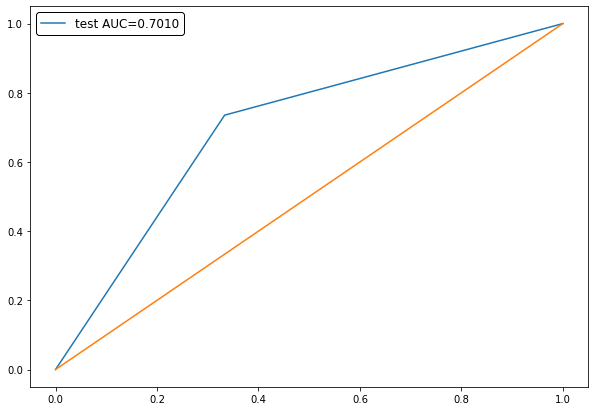

In [43]:
roc_auc_plot(y_val, y_val_predict)

In [50]:
clf.score(x_val, y_val)

0.7049180327868853

In [44]:
rfc = RandomForestClassifier()

In [45]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [46]:
y_val_predict_rfc = rfc.predict_proba(x_val)[:, 1]

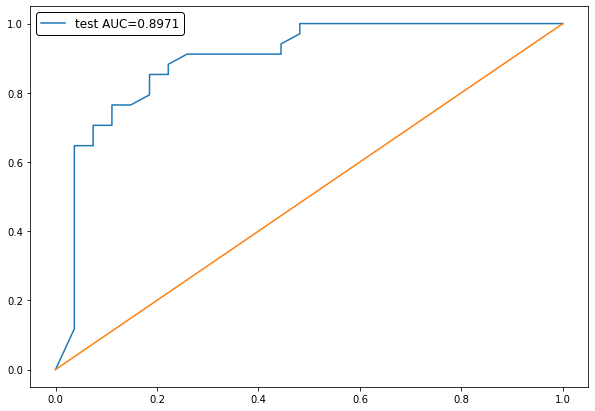

In [47]:
roc_auc_plot(y_val, y_val_predict_rfc)

In [49]:
rfc.score(x_val, y_val)

0.8360655737704918

## Бустинг GradientBoostingClassifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [57]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

GradientBoostingClassifier()

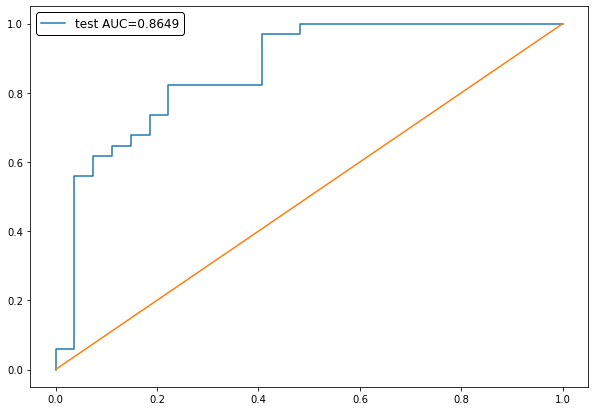

In [59]:
y_val_predict_gbc = gbc.predict_proba(x_val)[:, 1]
roc_auc_plot(y_val, y_val_predict_gbc)

In [60]:
gbc.score(x_val, y_val)

0.7868852459016393

## Стэкинг StackingClassifier

In [118]:
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import StackingClassifier

In [135]:
def get_models():
    models = list()
    models.append(('lr', LogisticRegression()))
    models.append(('knn', KNeighborsClassifier()))
    models.append(('cart', DecisionTreeClassifier()))
    models.append(('svm', SVC(probability=True)))
    models.append(('bayes', GaussianNB()))
    return models

def get_stacking():
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
#   level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for _, model in models:
        yhat = model.predict_proba(X_test)
        meta_X.append(yhat)
        meta_X = hstack(meta_X)
    return blender.predict(meta_X)

models = get_models()
results = list()
for name, model in models:
    scores = evaluate_model(model, X, Y)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.846 (0.067)
>knn 0.851 (0.057)
>cart 0.736 (0.071)
>svm 0.830 (0.069)
>bayes 0.815 (0.082)


In [136]:
stack = get_stacking()

In [137]:
stack.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()), ('svm', SVC()),
                               ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression())

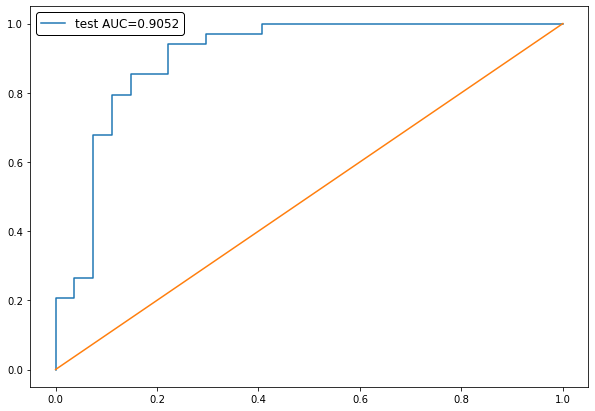

In [138]:
y_val_predict_stack = stack.predict_proba(x_val)[:, 1]
roc_auc_plot(y_val, y_val_predict_stack)

In [139]:
stack.score(x_val, y_val)

0.819672131147541

## Результаты

In [140]:
final_scores = list()
final_scores.append(clf.score(x_val, y_val))
final_scores.append(rfc.score(x_val, y_val))
final_scores.append(gbc.score(x_val, y_val))
final_scores.append(stack.score(x_val, y_val))

In [141]:
final_scores

[0.7049180327868853, 0.8360655737704918, 0.7868852459016393, 0.819672131147541]

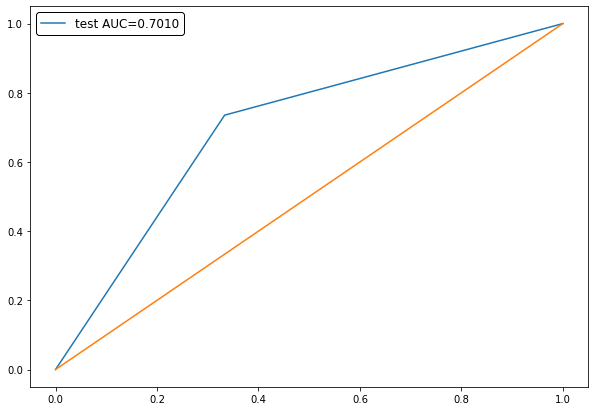

In [142]:
roc_auc_plot(y_val, y_val_predict)

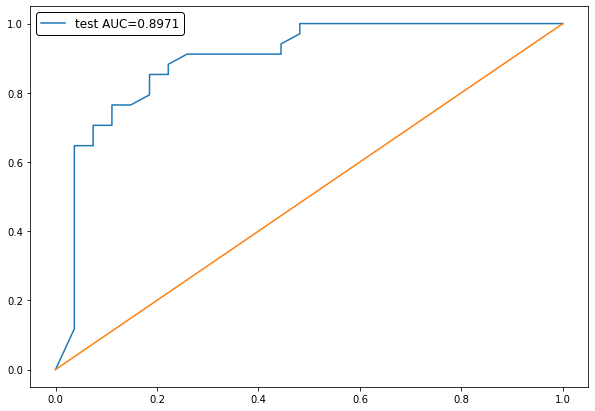

In [143]:
roc_auc_plot(y_val, y_val_predict_rfc)

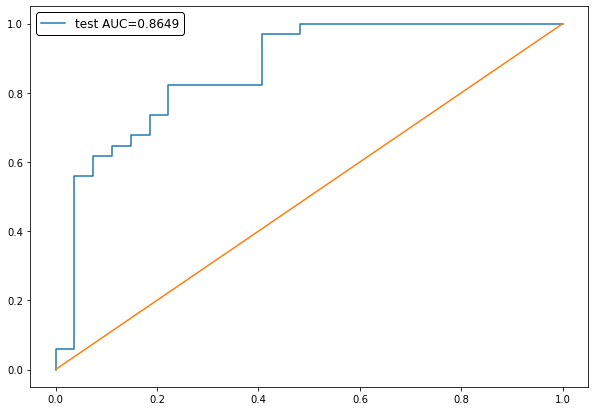

In [144]:
roc_auc_plot(y_val, y_val_predict_gbc)

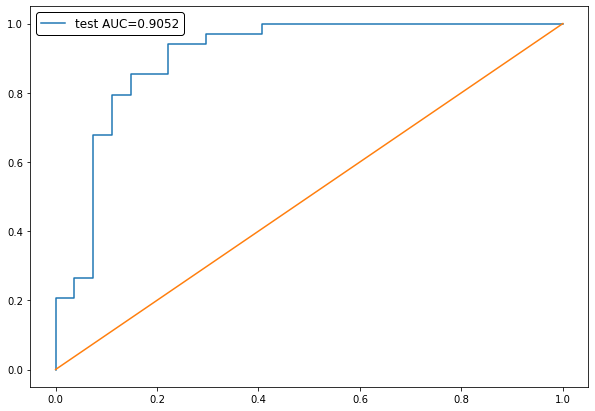

In [145]:
roc_auc_plot(y_val, y_val_predict_stack)